In [1]:
## import the tools
import torch
import glob
from pathlib import Path
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors as NN
import glob
import pandas as pd
import ipdb
import laspy
import open3d as o3d
from tqdm.notebook import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
## import the model tools
from torch_geometric.transforms import Compose
from torch_points3d.core.data_transform import MinPoints,XYZFeature, AddFeatsByKeys, GridSampling3D
from torch_points3d.applications.pretrained_api import PretainedRegistry
from torch_geometric.data import Batch, Dataset, Data ,DataLoader


In [3]:
## to find the neighbor points prediction
from sklearn.neighbors import BallTree, KDTree
import numpy as np
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    # src : whole gt points in a file 
    tree = KDTree(candidates, leaf_size=20, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    closest = np.squeeze(indices)
    closest_dist = distances

    return closest

In [4]:
model_folder = "2023-03-29/13-31-16/"
root_path = "/home/jf/Documents/msc/torch-3dpoints-powerline/"
pl_models_path = root_path+ "outputs/" + model_folder + "SEUNet18.pt" 
model = torch.load(pl_models_path)
model['run_config']['data']['dataroot'] = '/home/jf/msc_data'
torch.save(model, root_path+ "outputs/" + model_folder + "SEUNet18.pt")
print(model['run_config']["data"]["train_transform"])

[{'transform': 'MinPoints', 'lparams': [512]}, {'transform': 'XYZFeature', 'params': {'add_x': False, 'add_y': False, 'add_z': True}}, {'transform': 'AddFeatsByKeys', 'params': {'list_add_to_x': [True], 'feat_names': ['pos_z'], 'delete_feats': [True]}}, {'transform': 'GridSampling3D', 'params': {'size': '${data.first_subsampling}', 'quantize_coords': True, 'mode': 'last'}}]


# MAKE SURE THESE PARAM MATCHES THE ONES ABOVE !!!!!

In [5]:
## transformer
pos_z = [ "pos_z" ]
list_add_to_x = [ True ]
delete_feats = [ True ]
lparams = ['512']

first_subsampling = model['run_config']["data"]["first_subsampling"]
transform_test = Compose([MinPoints(512),
                     XYZFeature(add_x=False, add_y=False, add_z= True),
                     AddFeatsByKeys(list_add_to_x=list_add_to_x, feat_names= pos_z,delete_feats=delete_feats),
                     GridSampling3D(mode='last', size=first_subsampling, quantize_coords=True)
                     ])

In [6]:
## powerline model
model_folder = "2023-03-29/13-31-16/"
root_path = "/home/jf/Documents/msc/torch-3dpoints-powerline/"
pl_models_path = root_path+ "outputs/" + model_folder + "SEUNet18" 

model_pl = PretainedRegistry.from_file(pl_models_path).cuda()

INFO - 2023-04-07 13:24:40,108 - model_checkpoint - Loading checkpoint from /home/jf/Documents/msc/torch-3dpoints-powerline/outputs/2023-03-29/13-31-16/SEUNet18.pt


loading processed train split
Total of 1516 samples in train set.
loading processed val split
Total of 100 samples in val set.
loading processed test split
Total of 131 samples in test set.


INFO - 2023-04-07 13:24:41,597 - model_checkpoint - Available weights : ['latest', 'loss_seg', 'acc', 'macc', 'miou']
INFO - 2023-04-07 13:24:41,598 - model_checkpoint - Model loaded from SEUNet18.pt:latest
INFO - 2023-04-07 13:24:41,700 - bn_schedulers - Setting batchnorm momentum at 0.1


## Process with the normalize data

In [7]:
## load test pt with normalized

## load transform pt pre
processed_folder_name = model['run_config']['data']["processed_folder"] # "processed_hough"
data_root_path = model['run_config']['data']['dataroot'] + "/denmark"
processed_data_root_path = os.path.join(data_root_path, processed_folder_name)#"/home/jf/msc_data/denmark/processed_hough"
test_fold = processed_data_root_path + "/test_0_(0.1, 0.1)/"

pre_trans_path = test_fold + "/stats.pt"
vis_out_folder = processed_data_root_path + '/vis/'

pre_transform = torch.load(pre_trans_path)

In [8]:
print(f"{pre_transform=}")


pre_transform={'room_names': ['PUNKTSKY_00005_1km_6219_494', 'PUNKTSKY_00005_1km_6211_474'], 'room_coord_min': [array([ 4.9406794e+07,  6.2190000e+08, -2.6480000e+03]), array([ 4.7416593e+07,  6.2110000e+08, -2.6480000e+03])], 'room_coord_max': [array([4.94999990e+07, 6.21971228e+08, 1.39850000e+04]), array([4.74999990e+07, 6.21199999e+08, 1.39850000e+04])], 'room_coord_scale': [array([ 9320.5,  7122.8, 16633. ]), array([ 8340.6,  9999.9, 16633. ])], 'global_z': (-2648.0, 13985.0)}


In [10]:
## loop for every files
## delete files
global_z = pre_transform['global_z']
room_names = pre_transform['room_names']
room_coord_mins = pre_transform['room_coord_min']
room_coord_maxs = pre_transform['room_coord_max']
room_coord_scales = pre_transform['room_coord_scale']
# files = list(glob.glob(test_fold + "PUNKTSKY_00005_1km_6219_494*cloud*pt"))
files = list(glob.glob(test_fold + "*cloud*pt"))
#print(files)
for file in files:
#for file in glob.glob(test_fold + "*cloud*pt"):
    #print(file)
    sample = os.path.join(test_fold, file)
    pt_data = torch.load(sample)
    room_index = pt_data['room_idx']
    room_name = room_names[room_index]
    vis_out = os.path.join(vis_out_folder, room_name)
    Path(vis_out_folder).mkdir(exist_ok=True, parents=True)
    # print(vis_out)
    # ipdb.set_trace()
    # print(f"{pos_=}")
    #print(room_name)
    #print(f"")
    a[room_name].append(room_index)

    room_coord_scale = room_coord_scales[room_index]
    pos_ = pt_data['points']
    pt_ori = pos_ * room_coord_scale + room_coord_mins[room_index]
    data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
    # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
    data_s.y = torch.zeros(data_s.batch.shape).long()
    f = get_nearest(pos_, data_s.pos)
    # print(f"{room_index =}")
    # print(f"{room_name =}")
    # print(f"{vis_out =}")
    # print(f"{room_coord_scale =}")
    # print(f"{pos_ =}")
    # print(f"{data_s.pos =}")
    # print(f"{f =}")


    with torch.no_grad():
        model_pl.eval()
        model_pl.set_input(data_s, "cuda")
        model_pl.forward(data_s)
    
    pre = model_pl.output.cpu().numpy()
    m = torch.nn.functional.softmax(torch.tensor(pre), dim=1)
    cla_pre = np.argmax(m, axis=1)
    pre_ori = np.arange(len(pos_))
    if len(pos_) == 1:
        print(file)
        print(data_s)
        pre_ori[0] = cla_pre[0]
    else:
        for i in pre_ori:
            #print(i)
            # print(f"{pre_ori[i] = }")
            # print(f"{cla_pre[f[i]] = }")
            # print(f"{f[i] = }")
            pre_ori[i] = cla_pre[f[i]]
    combine_pre = np.column_stack((pt_ori, pre_ori.T))
#     import ipdb;ipdb.set_trace()
    vis_out = vis_out_folder + room_name +'pre.txt'
    if os.path.exists(vis_out):
        file_save = open(vis_out, 'a')
    else:
        file_save = open(vis_out, 'w')

    file_save = open(vis_out_folder + room_name +'pre.txt', 'a')
    np.savetxt(file_save, combine_pre, fmt = '%1.5f')
#     file_save.write("\n")    
#     break
print("save finished")

/home/jf/msc_data/denmark/processed_hough/test_0_(0.1, 0.1)/PUNKTSKY_00005_1km_6219_494_cloud_19.pt
Batch(batch=[1], coords=[1, 3], grid_size=[1], pos=[1, 3], x=[1, 1], y=[1])
save finished


### Simple vis

In [13]:
## read path
filename = "PUNKTSKY_00005_1km_6219_494"
vis_out_folder
pred_path = os.path.join(vis_out_folder, filename+"pre.txt")
pred_data = pd.read_csv(pred_path, sep=" ", header=None).values
pred_data, pred_data.shape

(array([[4.94504490e+07, 6.21904102e+08, 5.78300000e+03, 1.00000000e+00],
        [4.94504790e+07, 6.21904100e+08, 5.78500000e+03, 1.00000000e+00],
        [4.94504300e+07, 6.21904135e+08, 5.78000000e+03, 1.00000000e+00],
        ...,
        [4.94274950e+07, 6.21928478e+08, 5.87500000e+03, 1.00000000e+00],
        [4.94275240e+07, 6.21928475e+08, 5.87500000e+03, 1.00000000e+00],
        [4.94275510e+07, 6.21928472e+08, 5.87300000e+03, 1.00000000e+00]]),
 (8718407, 4))

In [14]:
## vis
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook

In [15]:
idx = np.arange(len(pred_data))
np.random.shuffle(idx)
idx = idx[:30000]

vmin = pred_data[idx, -1].min()
vmax = pred_data[idx, -1].max()
cm = plt.colormaps['RdYlBu']

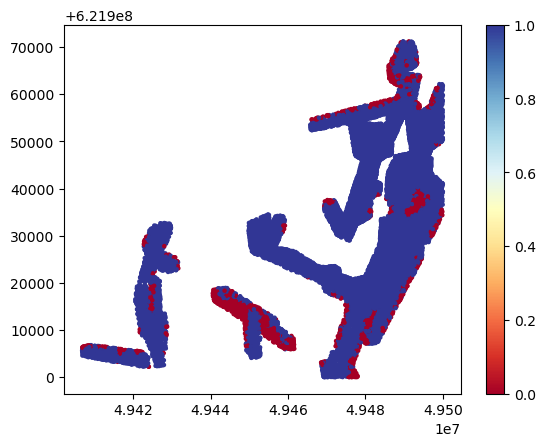

In [16]:
plt.figure()
sc = plt.scatter(pred_data[idx, 0], pred_data[idx, 1], c =pred_data[idx, -1],
                cmap=cm, vmin=vmin, vmax=vmax, s=5
            )
plt.colorbar(sc)

# Convert prediction from pt to las file

## Reading in the laspy data. Both the unprocessed and the processed data

In [17]:
normal_laz_file = os.path.join(data_root_path, "raw", "test",filename+".laz")
processed_laz_file = os.path.join(data_root_path, "raw", "test", "NewLaz", filename+".laz")
print(normal_laz_file)
print(processed_laz_file)
non_processed_laz = laspy.read(normal_laz_file, laz_backend=laspy.compression.LazBackend.LazrsParallel)
processed_laz = laspy.read(processed_laz_file, laz_backend=laspy.compression.LazBackend.LazrsParallel)
non_processed_point_data = np.stack([non_processed_laz.X, non_processed_laz.Y, non_processed_laz.Z], axis=0).transpose((1, 0))
processed_point_data = np.stack([processed_laz.X, processed_laz.Y, processed_laz.Z], axis=0).transpose((1, 0))
print(len(non_processed_point_data))
print(len(processed_point_data))


/home/jf/msc_data/denmark/raw/test/PUNKTSKY_00005_1km_6219_494.laz
/home/jf/msc_data/denmark/raw/test/NewLaz/PUNKTSKY_00005_1km_6219_494.laz
4095
4095
19684629
4364059


### Getting the powerline coordinates

In [18]:
powerline_pts = pred_data[np.where(pred_data[:,3] == 1)].copy()
powerline_pts_coord = powerline_pts[:,:-1].astype(np.int32)

#### Sanity checks for converting from pt to las data


In [19]:
print(f"There are {pred_data.shape} points in the las file")
print(f"There are {pred_data.shape} points from the pt files")
#Some points could get lost if there are not that many points in the tile


There are (8718407, 4) points in the las file
There are (8718407, 4) points from the pt files


In [20]:
### WRONG
# There are (4359162, 4) points in the las file
# There are (4359162, 4) points from the pt files
## CORRECT
# There are (4359245, 4) points in the las file
# There are (4359245, 4) points from the pt files

In [21]:
print(powerline_pts_coord[:10])
print(processed_point_data[:10])

print(f"laz data x max {np.max(processed_point_data[:,0])}")
print(f"pt x max {np.max(powerline_pts_coord[:,0])}")
print(f"laz data y max {np.max(processed_point_data[:,1])}")
print(f"pt y max {np.max(powerline_pts_coord[:,1])}")
print(f"laz data z max {np.max(processed_point_data[:,2])}")
print(f"pt z max {np.max(powerline_pts_coord[:,2])}")


[[ 49450449 621904102      5783]
 [ 49450479 621904100      5785]
 [ 49450430 621904135      5780]
 [ 49450421 621904132      6121]
 [ 49450448 621904128      6253]
 [ 49450485 621904129      5782]
 [ 49450474 621904126      6207]
 [ 49450468 621904124      6425]
 [ 49450495 621904121      6464]
 [ 49450524 621904119      6383]]
[[ 49420222 621902558      6254]
 [ 49420260 621902563      6253]
 [ 49420132 621902577      6256]
 [ 49420171 621902583      6254]
 [ 49420211 621902588      6255]
 [ 49420244 621902592      6255]
 [ 49420016 621902596      6255]
 [ 49420050 621902600      6255]
 [ 49420085 621902605      6255]
 [ 49420121 621902610      6258]]
laz data x max 49499999
pt x max 49499998
laz data y max 621971228
pt y max 621971227
laz data z max 17597
pt z max 9717


In [22]:
## WRONG
# laz data x max 49499999
# pt x max 47509797
# laz data y max 621971228
# pt y max 621171227
# laz data z max 17597
# pt z max 9717
## CORRECT
# laz data x max 49499999
# pt x max 49499998
# laz data y max 621971228
# pt y max 621971227
# laz data z max 17597
# pt z max 9717

### Viz the las files

In [23]:
# Visualise all data
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(non_processed_point_data)
o3d.visualization.draw_geometries([geom])
print(np.sum(non_processed_laz.classification == 14))

18363


In [24]:
# Visualise all data after removal of points
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(processed_point_data)
o3d.visualization.draw_geometries([geom])
print(np.sum(processed_laz.classification == 14))

18363


### Add dimension to processed las file 

In [25]:
processed_laz.add_extra_dim(laspy.ExtraBytesParams(
    name="prediction",
    type=np.uint8,
    description="The prediction of the model"
))

In [26]:
# Get the idx of the powerline points in the las file
idx = get_nearest(powerline_pts_coord,processed_point_data)
pred = np.zeros(len(processed_point_data))
pred[idx] = 1
processed_laz.prediction = pred

#### Viz all the powerline points

In [27]:
powerline_las = processed_laz[processed_laz.prediction == 1]
powerline_points_data = np.stack([powerline_las.X, powerline_las.Y, powerline_las.Z], axis=0).transpose((1, 0))

In [28]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(powerline_points_data)
o3d.visualization.draw_geometries([geom])

#### Save the new file

In [29]:
processed_data_root_path = os.path.join(data_root_path, processed_folder_name)#"/home/jf/msc_data/denmark/processed_hough"
eval_folder = os.path.join(processed_data_root_path, "eval")
Path(eval_folder).mkdir(exist_ok=True, parents=True)
eval_file_name = os.path.join(eval_folder, filename+".laz")
processed_laz.write(str(eval_file_name), do_compress =True, laz_backend=laspy.compression.LazBackend.LazrsParallel)

### check the individual pt


In [30]:
onesample = test_fold + "PUNKTSKY_00005_1km_6211_474_cloud_56.pt"
#onesample = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed/test_0_(0.05, 0.05)/PUNKTSKY_00005_1km_6090_507_cloud_335.pt"
pt_data = torch.load(onesample)
pt_data['points'].shape, pt_data['points']
data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
data_s.y = torch.zeros(data_s.batch.shape).long()


In [31]:
### check the individual pt

# pos_ = pt_data['points']
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
# data_s.y = torch.zeros(data_s.batch.shape).long()
# f = get_nearest(pos_, data_s.pos)
# f.shape, f
# f.max(), data_s.pos.shape

# with torch.no_grad():
#     model_pl.set_input(data_s, "cuda")
#     model_pl.forward(data_s)

# pre = model_pl.output.cpu().numpy()
# pre.shape

In [32]:
## change the model config path
# model_path = "./outputs/2022-02-16/11-00-40/PointNet_old.pt"
# model = torch.load(model_path)
# model['run_config']['data']['dataroot'] = '/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/'
# torch.save(model, "./outputs/2022-02-16/11-00-40/PointNet_modified.pt")

In [33]:
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_for_exp_allClasses/denmark/processed/"
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/denmark/processed/"

processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed"

test_fold = processed_split_folder + "test_0_(0.05, 0.05)/"
processed_file_names = list(Path(test_fold).glob("*cloud_*.pt"))
len(processed_file_names)


0